In [2]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import kgof.density as density
import kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

from src.kgof.ksdagg import ksdagg_wild_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed = 1
tf.random.set_seed(seed)

In [4]:
dim = 2

k = 2
delta = 2.
ratio_sample = 0.3
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

2022-04-12 16:13:54.014952: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-12 16:13:54.014988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-04-12 16:13:54.014994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-04-12 16:13:54.015107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-04-12 16:13:54.015126: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-04-12 16:13:54.015130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-04-12 16:13:54.015966: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [5]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

# samples_off = proposal_off.sample(n)
# samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
# samples_off_df["type"] = "off"

# samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

In [6]:
# _ = sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")

In [8]:
num_boot = 800
alpha = 0.05

B2 = 500
B3 = 50
l_minus = 0
l_plus = 10

In [10]:
ksdagg_wild_test(
    seed,
    X=samples_on,
    log_prob_fn=log_prob_fn,
    alpha=alpha,
    beta_imq=0.5,
    kernel_type="imq",
    weights_type="uniform",
    l_minus=0,
    l_plus=10,
    B1=num_boot,
    B2=B2,
    B3=B3,
)

0

In [104]:
def repeat_experiment(nrep, target_log_prob, sample_dist):
    rej_list = []
    p_val_list = []
    for _ in trange(nrep):
        samples_on = sample_dist.sample(n)

        with tf.GradientTape() as tape:
            tape.watch(samples_on)
            log_prob = target_log_prob(samples_on)

        score_on = tape.gradient(log_prob, samples_on)

        # test result
        res = ksdagg_wild(
            seed,
            X=samples_on.numpy(),
            score_X=score_on.numpy(),
            alpha=alpha,
            beta_imq=0.5,
            kernel_type="imq",
            weights_type="uniform",
            l_minus=0,
            l_plus=10,
            B1=num_boot,
            B2=B2,
            B3=B3,
        )

        rej_list.append(res[0])
        p_val_list.append(res[1])

    return rej_list, p_val_list

In [105]:
nrep = 100
res_list = repeat_experiment(nrep, log_prob_fn, target)

  0%|          | 0/100 [00:00<?, ?it/s]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
num of disagreed restuls: 0


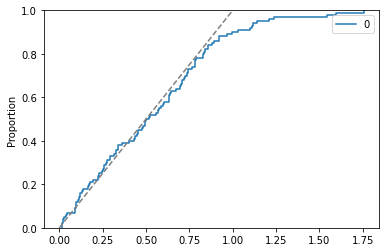

In [106]:
print((np.array(res_list[0]) == (np.array(res_list[1]) < 0.05)))#[20:25]
print("num of disagreed restuls:", np.sum((np.array(res_list[0]) != (np.array(res_list[1]) < 0.05))))

sns.ecdfplot(pd.DataFrame(res_list[1]))
plt.plot([0, 1], [0, 1], color="grey", linestyle="dashed")

In [98]:
nrep = 100
res_list_off = repeat_experiment(nrep, log_prob_fn, proposal_off)

  0%|          | 0/100 [00:00<?, ?it/s]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
num of disagreed restuls: 0


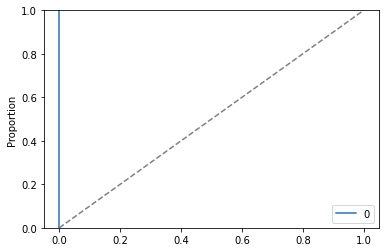

In [99]:
print((np.array(res_list_off[0]) == (np.array(res_list_off[1]) < 0.05)))#[20:25]
print("num of disagreed restuls:", np.sum((np.array(res_list_off[0]) != (np.array(res_list_off[1]) < 0.05))))

sns.ecdfplot(pd.DataFrame(res_list_off[1]))
plt.plot([0, 1], [0, 1], color="grey", linestyle="dashed")